In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from scipy.stats import norm, rankdata

import warnings
import gc
import os
import time
import sys
import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1)

/Users/aeternae/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### 数据载入

In [2]:
path = '/Users/aeternae/Desktop/Data/MetroRace/'
test_28 = pd.read_csv(path + 'Metro_testA/testA_record_2019-01-28.csv')
test_29 = pd.read_csv(path + 'Metro_testA/testA_submit_2019-01-29.csv')

In [3]:
station_con = pd.read_csv(path + 'Metro_roadMap.csv')
del station_con['Unnamed: 0']
station_con.head()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_28.head()

,time,lineID,stationID,deviceID,status,userID,payType
0,2019-01-28 00:00:04,B,33,1587,0,Aad6ad59dfdd470bfdfdb0d2959db068b,0
1,2019-01-28 00:00:04,C,63,2933,0,Bab97d7b32891b8cb5451e80b73b23d70,1
2,2019-01-28 00:00:06,C,63,2934,0,Dda829d9f38d0a28f1e4ae84a34e846dc,3
3,2019-01-28 00:00:06,C,39,1839,0,Cc397069031ab762d75d613291cd68cda,2
4,2019-01-28 00:00:07,B,33,1588,0,Ba83c695d27b4d376bfde3f755e4b677f,1


In [5]:
def get_base_features(df_):
    
    df = df_.copy()
    df1 = df_.copy()
    
    date = df['time'][0][8:10]
    df['startTime'] = df['time'].apply(lambda x: x[:15].replace(date, '29') + '0:00') 
    df = df.groupby(['startTime','stationID']).status.agg(['count', 'sum']).reset_index()
    
    df = pd.merge(test_29, df, how='left', on=['stationID', 'startTime']) #左连接，保留test_29所有信息
    df['time'] = df['startTime'].apply(lambda x: x[:15].replace('29', date) + '0:00')
    del df['startTime'], df['endTime']
    
   
    # base time
    df['day']     = df['time'].apply(lambda x: int(x[8:10]))
    df['week']    = pd.to_datetime(df['time']).dt.dayofweek + 1
    df['weekend'] = (pd.to_datetime(df.time).dt.weekday >=5).astype(int)
    df['hour']    = df['time'].apply(lambda x: int(x[11:13]))
    df['minute']  = df['time'].apply(lambda x: int(x[14:15]+'0'))
    del df['time']
    
    # count,sum
#     result = df.groupby(['stationID', 'day', 'hour', 'minute']).status.agg(['count', 'sum']).reset_index()
    
    # nunique 
    
    tmp = 1 - df1.groupby(['stationID'])['userID'].nunique() / df1.groupby(['stationID'])['userID'].count()
    df  = df.merge(tmp, on=['stationID'], how='left')
    df.rename(columns={'userID':'samePeo'}, inplace = True)
#     tmp     = df.groupby(['stationID','hour'])['deviceID'].nunique().reset_index(name='nuni_deviceID_of_stationID_hour')
#     result  = result.merge(tmp, on=['stationID','hour'], how='left')
#     tmp     = df.groupby(['stationID','hour','minute'])['deviceID'].nunique().\
#                                            reset_index(name='nuni_deviceID_of_stationID_hour_minute')
#     result  = result.merge(tmp, on=['stationID','hour','minute'], how='left')
 
    
    # in, out
    df['inNums']  = df['sum']
    df['outNums'] = df['count'] - df['sum']
    
    df['day_since_first'] = df['day'] - 1 
    df.fillna(0, inplace=True)
    del df['sum'], df['count']
    
    
    return df

In [7]:
data_list = os.listdir(path + 'Metro_train/')
data_list

['record_2019-01-23.csv',
 'record_2019-01-22.csv',
 'record_2019-01-08.csv',
 'record_2019-01-20.csv',
 'record_2019-01-21.csv',
 'record_2019-01-09.csv',
 'record_2019-01-25.csv',
 'record_2019-01-19.csv',
 'record_2019-01-18.csv',
 'record_2019-01-24.csv',
 'record_2019-01-02.csv',
 'record_2019-01-16.csv',
 'record_2019-01-17.csv',
 'record_2019-01-03.csv',
 'record_2019-01-15.csv',
 'record_2019-01-01.csv',
 'record_2019-01-14.csv',
 'record_2019-01-10.csv',
 'record_2019-01-04.csv',
 'record_2019-01-05.csv',
 'record_2019-01-11.csv',
 'record_2019-01-07.csv',
 'record_2019-01-13.csv',
 'record_2019-01-12.csv',
 'record_2019-01-06.csv']

In [8]:
df = pd.DataFrame()

In [9]:
for i in range(0, len(data_list)):
    print(data_list[i], i)
    dfi = pd.read_csv(path + 'Metro_train/' + data_list[i])
    dfi = get_base_features(dfi)
    df = pd.concat([df, dfi], axis=0, ignore_index=True)

record_2019-01-23.csv 0
record_2019-01-22.csv 1
record_2019-01-08.csv 2
record_2019-01-20.csv 3
record_2019-01-21.csv 4
record_2019-01-09.csv 5
record_2019-01-25.csv 6
record_2019-01-19.csv 7
record_2019-01-18.csv 8
record_2019-01-24.csv 9
record_2019-01-02.csv 10
record_2019-01-16.csv 11
record_2019-01-17.csv 12
record_2019-01-03.csv 13
record_2019-01-15.csv 14
record_2019-01-01.csv 15
record_2019-01-14.csv 16
record_2019-01-10.csv 17
record_2019-01-04.csv 18
record_2019-01-05.csv 19
record_2019-01-11.csv 20
record_2019-01-07.csv 21
record_2019-01-13.csv 22
record_2019-01-12.csv 23
record_2019-01-06.csv 24


In [10]:
df = df.sort_values(['stationID', 'day']).reset_index(drop=True)
df.drop(df[df['day']==1].index, inplace=True)   #删除元旦数据
df.head()

,stationID,inNums,outNums,day,week,weekend,hour,minute,samePeo,day_since_first
144,0,0.0,4.0,2,3,0,0,0,0.293261,1
145,0,0.0,0.0,2,3,0,0,10,0.293261,1
146,0,0.0,3.0,2,3,0,0,20,0.293261,1
147,0,0.0,0.0,2,3,0,0,30,0.293261,1
148,0,0.0,0.0,2,3,0,0,40,0.293261,1


### 构建基础模型

In [11]:
# 划分data，label
df_X = df.iloc[:, [0,3,4,5,6,7,8,9]]
df_y = df.iloc[:, [1,2]]

In [12]:
test_28 = pd.read_csv(path + 'Metro_testA/testA_record_2019-01-28.csv')

In [13]:
df28 = get_base_features(test_28)

In [14]:
df28_X = df28.iloc[:, [0,3,4,5,6,7,8,9]]
df28_y = df28.iloc[:, [1,2]]

#### randomForest

In [75]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, oob_score=True, n_jobs=-1)
rf_reg.fit(df_X, df_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [16]:
rf_reg.oob_score_

0.9698007412551612

In [17]:
df28_y_pre = rf_reg.predict(df28_X)

In [18]:
rf_reg.score(df28_X, df28_y)

0.9451314308347849

In [19]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df28_y, df28_y_pre)

17.97187054183813

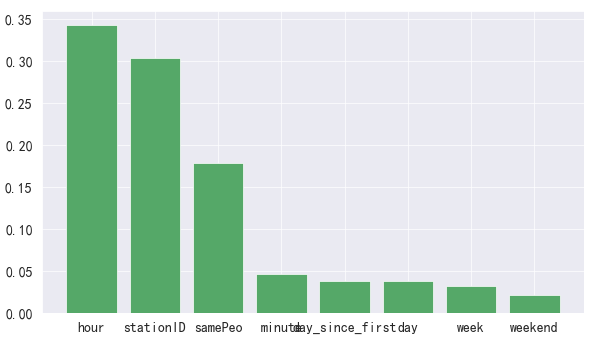

In [86]:
feature = df_X.columns
importances = rf_reg.feature_importances_
index = np.argsort(importances)[::-1]
feature[index]

plt.figure(figsize = (14, 8), dpi = 50)
plt.bar(feature[index], importances[index], color="g", align="center")
plt.tick_params(labelsize=20) 

In [22]:
# sub = pd.read_csv(path + '/Metro_testA/testA_submit_2019-01-29.csv')
# sub['inNums']   = df28_y_pre[:, 0]
# sub['outNums']  = df28_y_pre[:, 1]
# # 结果修正
# #sub.loc[sub.inNums<0 , 'inNums']  = 0
# #sub.loc[sub.outNums<0, 'outNums'] = 0
# sub[['stationID', 'startTime', 'endTime', 'inNums', 'outNums']].to_csv(path + '/Metro_testA/sub_rf.csv', index=False)

####  xgb

In [20]:
import lightgbm as lgb
import xgboost as xgb

In [21]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size = 0.2, random_state=1)

train_X = train.iloc[:, [0,3,4,5,6,7,8,9]]
train_y_in  = train.iloc[:, 1]
train_y_out = train.iloc[:, 2]

valid_X = valid.iloc[:, [0,3,4,5,6,7,8,9]]
valid_y_in  = valid.iloc[:, 1]
valid_y_out = valid.iloc[:, 2]

 
#xgb矩阵赋值
xgb_train_in = xgb.DMatrix(train_X, label=train_y_in)
xgb_val_in = xgb.DMatrix(valid_X, label=valid_y_in)

xgb_train_out = xgb.DMatrix(train_X, label=train_y_out)
xgb_val_out = xgb.DMatrix(valid_X, label=valid_y_out)

xgb_test = xgb.DMatrix(df28_X)
y_test_in  = df28.iloc[:, 1]
y_test_out = df28.iloc[:, 2]

In [22]:
watchlist = [(xgb_train_in, 'train'), (xgb_val_in, 'val')]
xgb_params = {'eta': 0.05, 'gamma': 0, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 
              'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True}

In [23]:
xgb_reg_in = xgb.train(xgb_params, xgb_train_in, num_boost_round=2000, evals=watchlist,
                   early_stopping_rounds=100, verbose_eval=200)

[0]	train-mae:84.5548	val-mae:83.8538
Multiple eval metrics have been passed: 'val-mae' will be used for early stopping.

Will train until val-mae hasn't improved in 100 rounds.
[100]	train-mae:26.4084	val-mae:26.3129
[200]	train-mae:21.2436	val-mae:21.4824
[300]	train-mae:18.3831	val-mae:18.9055
[400]	train-mae:16.7909	val-mae:17.4774
[500]	train-mae:15.5086	val-mae:16.3615
[600]	train-mae:14.5842	val-mae:15.5623
[700]	train-mae:13.8508	val-mae:14.9339
[800]	train-mae:13.3179	val-mae:14.4991
[900]	train-mae:12.7889	val-mae:14.0658
[1000]	train-mae:12.4187	val-mae:13.7758
[1100]	train-mae:12.0225	val-mae:13.455
[1200]	train-mae:11.7507	val-mae:13.2622
[1300]	train-mae:11.482	val-mae:13.0734
[1400]	train-mae:11.2661	val-mae:12.9318
[1500]	train-mae:11.0535	val-mae:12.7929
[1600]	train-mae:10.8679	val-mae:12.6693
[1700]	train-mae:10.7197	val-mae:12.5785
[1800]	train-mae:10.5651	val-mae:12.4823
[1900]	train-mae:10.4221	val-mae:12.4002
[2000]	train-mae:10.2966	val-mae:12.325
[2100]	train-m

In [24]:
xgb_reg_in.save_model('/Users/aeternae/Desktop/Analyse/Metro_predict/xgb_base_in.model')

In [25]:
xgb_pre_in = xgb_reg_in.predict(xgb_test, ntree_limit=xgb_reg_in.best_ntree_limit)

In [27]:
mean_absolute_error(y_test_in, xgb_pre_in)

17.272286692664885

In [32]:
xgb_in_new = xgb.Booster(model_file='xgb.model')

In [33]:
pre_in = xgb_in_new.predict(xgb_test)
mean_absolute_error(y_test_in, pre_in)

16.334638903809225

In [34]:
xgb_reg_in.feature_names

['stationID',
 'day',
 'week',
 'weekend',
 'hour',
 'minute',
 'samePeo',
 'day_since_first']

In [35]:
from xgboost import plot_importance

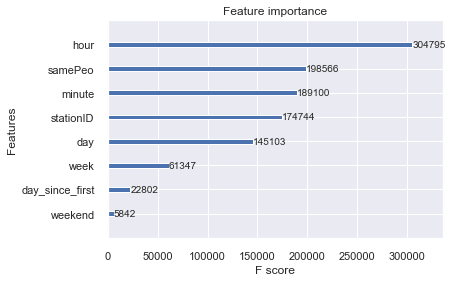

In [36]:
plot_importance(xgb_reg_in)

### 增加特征

#### 站点特征

In [39]:
station_poi = pd.read_csv('/Users/aeternae/Desktop/Analyse/Metro_predict/station_poi/station_poi_data.csv')
station_poi.head()

,stationID,线路,站点,体育休闲服务,医疗保健服务,住宿服务,风景名胜,科教文化服务,交通枢纽,生活类服务,公司,住宅区
0,0,1,湘湖站,3,5,2,3,6,21,82,22,10
1,1,1,滨康路站,12,29,30,4,42,68,614,195,44
2,2,1,西兴站,19,12,25,1,34,87,642,630,13
3,3,1,滨和路站,39,89,22,1,169,115,1638,157,18
4,4,1,江陵路站,47,44,38,4,134,207,1649,872,8


In [40]:
df_poi = pd.merge(df, station_poi, how='left', on=['stationID'])
df_poi.head()

,stationID,inNums,outNums,day,week,weekend,hour,minute,samePeo,day_since_first,...,站点,体育休闲服务,医疗保健服务,住宿服务,风景名胜,科教文化服务,交通枢纽,生活类服务,公司,住宅区
0,0,0.0,4.0,2,3,0,0,0,0.293261,1,...,湘湖站,3,5,2,3,6,21,82,22,10
1,0,0.0,0.0,2,3,0,0,10,0.293261,1,...,湘湖站,3,5,2,3,6,21,82,22,10
2,0,0.0,3.0,2,3,0,0,20,0.293261,1,...,湘湖站,3,5,2,3,6,21,82,22,10
3,0,0.0,0.0,2,3,0,0,30,0.293261,1,...,湘湖站,3,5,2,3,6,21,82,22,10
4,0,0.0,0.0,2,3,0,0,40,0.293261,1,...,湘湖站,3,5,2,3,6,21,82,22,10


In [41]:
df_poi.columns

Index(['stationID', 'inNums', 'outNums', 'day', 'week', 'weekend', 'hour',
       'minute', 'samePeo', 'day_since_first', '线路', '站点', '体育休闲服务', '医疗保健服务',
       '住宿服务', '风景名胜', '科教文化服务', '交通枢纽', '生活类服务', '公司', '住宅区'],
      dtype='object')

In [42]:
use_columns = ['stationID', '线路', 'inNums', 'outNums', 'day', 'week', 'weekend', 'hour',
       'minute', 'samePeo', 'day_since_first', '体育休闲服务', '医疗保健服务',
       '住宿服务', '风景名胜', '科教文化服务', '交通枢纽', '生活类服务', '公司', '住宅区']

In [110]:
df_train = df_poi.loc[:, use_columns]
df_train.rename(columns={'线路':'lineID'}, inplace = True)
df_train.head() 

,stationID,lineID,inNums,outNums,day,week,weekend,hour,minute,samePeo,day_since_first,体育休闲服务,医疗保健服务,住宿服务,风景名胜,科教文化服务,交通枢纽,生活类服务,公司,住宅区
0,0,1,0.0,4.0,2,3,0,0,0,0.293261,1,3,5,2,3,6,21,82,22,10
1,0,1,0.0,0.0,2,3,0,0,10,0.293261,1,3,5,2,3,6,21,82,22,10
2,0,1,0.0,3.0,2,3,0,0,20,0.293261,1,3,5,2,3,6,21,82,22,10
3,0,1,0.0,0.0,2,3,0,0,30,0.293261,1,3,5,2,3,6,21,82,22,10
4,0,1,0.0,0.0,2,3,0,0,40,0.293261,1,3,5,2,3,6,21,82,22,10


#### 天气特征

In [45]:
weather = pd.read_csv('/Users/aeternae/Desktop/Analyse/Metro_predict/station_poi/weather.csv')
weather.head()

,日期,最高气温℃,最低气温℃,天气,风向,风力
0,2019/1/1,6,1,小雨,北风,微风
1,2019/1/2,5,3,小雨,西北风,微风
2,2019/1/3,9,4,小雨,北风,微风
3,2019/1/4,8,5,中雨,北风,微风
4,2019/1/5,6,3,中雨,北风,微风


In [46]:
weather['day'] = weather['日期'].apply(lambda x: x[7:]).astype('int64')
weather['temp'] = (weather['最高气温℃'] + weather['最低气温℃']) / 2
weather['weather'] = weather['天气']
weather['weather'] = weather['weather'].apply(lambda x: x.replace('晴', '0'))
weather['weather'] = weather['weather'].apply(lambda x: x.replace('多云', '1'))
weather['weather'] = weather['weather'].apply(lambda x: x.replace('阴', '2'))
weather['weather'] = weather['weather'].apply(lambda x: x.replace('小雨', '3'))
weather['weather'] = weather['weather'].apply(lambda x: x.replace('中雨', '4'))
weather['weather'] = weather['weather'].astype('int64')

wea = weather[['day', 'temp', 'weather']]

In [49]:
wea.head()

,day,temp,weather
0,1,3.5,3
1,2,4.0,3
2,3,6.5,3
3,4,6.5,4
4,5,4.5,4


In [111]:
df_train = pd.merge(df_train, wea, how='left', on=['day'])
df_train.head()

,stationID,lineID,inNums,outNums,day,week,weekend,hour,minute,samePeo,...,医疗保健服务,住宿服务,风景名胜,科教文化服务,交通枢纽,生活类服务,公司,住宅区,temp,weather
0,0,1,0.0,4.0,2,3,0,0,0,0.293261,...,5,2,3,6,21,82,22,10,4.0,3
1,0,1,0.0,0.0,2,3,0,0,10,0.293261,...,5,2,3,6,21,82,22,10,4.0,3
2,0,1,0.0,3.0,2,3,0,0,20,0.293261,...,5,2,3,6,21,82,22,10,4.0,3
3,0,1,0.0,0.0,2,3,0,0,30,0.293261,...,5,2,3,6,21,82,22,10,4.0,3
4,0,1,0.0,0.0,2,3,0,0,40,0.293261,...,5,2,3,6,21,82,22,10,4.0,3


In [57]:
# 封装函数
def get_more_features(df_):
    df = df_.copy()
    df = get_base_features(df)
    
    df = pd.merge(df, station_poi, how='left', on=['stationID'])
    df = df.loc[:, use_columns]
    df.rename(columns={'线路':'lineID'}, inplace = True)
    df = pd.merge(df, wea, how='left', on=['day'])
    
    return df

#### randomForest

In [53]:
data_columns = [0,1,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
label_columns = [2,3]

In [54]:
df2_X = df_train.iloc[:, data_columns]
df2_y = df_train.iloc[:, label_columns]

In [55]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, oob_score=True, n_jobs=-1)
rf_reg.fit(df2_X, df2_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [56]:
rf_reg.oob_score_

0.9724653510934687

In [58]:
# 28号为周一
df28 = get_more_features(test_28)  
df28.head()

,stationID,lineID,inNums,outNums,day,week,weekend,hour,minute,samePeo,...,医疗保健服务,住宿服务,风景名胜,科教文化服务,交通枢纽,生活类服务,公司,住宅区,temp,weather
0,0,1,0.0,1.0,28,1,0,0,0,0.271884,...,5,2,3,6,21,82,22,10,7.0,1
1,0,1,0.0,2.0,28,1,0,0,10,0.271884,...,5,2,3,6,21,82,22,10,7.0,1
2,0,1,0.0,0.0,28,1,0,0,20,0.271884,...,5,2,3,6,21,82,22,10,7.0,1
3,0,1,0.0,0.0,28,1,0,0,30,0.271884,...,5,2,3,6,21,82,22,10,7.0,1
4,0,1,0.0,0.0,28,1,0,0,40,0.271884,...,5,2,3,6,21,82,22,10,7.0,1


In [59]:
df28_X = df28.iloc[:, data_columns]
df28_y = df28.iloc[:, label_columns]

In [60]:
df28_y_pre = rf_reg.predict(df28_X)

In [61]:
rf_reg.score(df28_X, df28_y)

0.9518964071302837

In [62]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df28_y, df28_y_pre)

17.225859586720922

In [63]:
feature = df2_X.columns
importances = rf_reg.feature_importances_
index = np.argsort(importances)[::-1]
feature[index]

Index(['hour', 'samePeo', 'stationID', '公司', 'minute', '生活类服务', 'week', 'day',
       'day_since_first', 'weekend', '科教文化服务', '住宅区', '住宿服务', 'temp', '风景名胜',
       '交通枢纽', '医疗保健服务', '体育休闲服务', 'weather', '线路'],
      dtype='object')

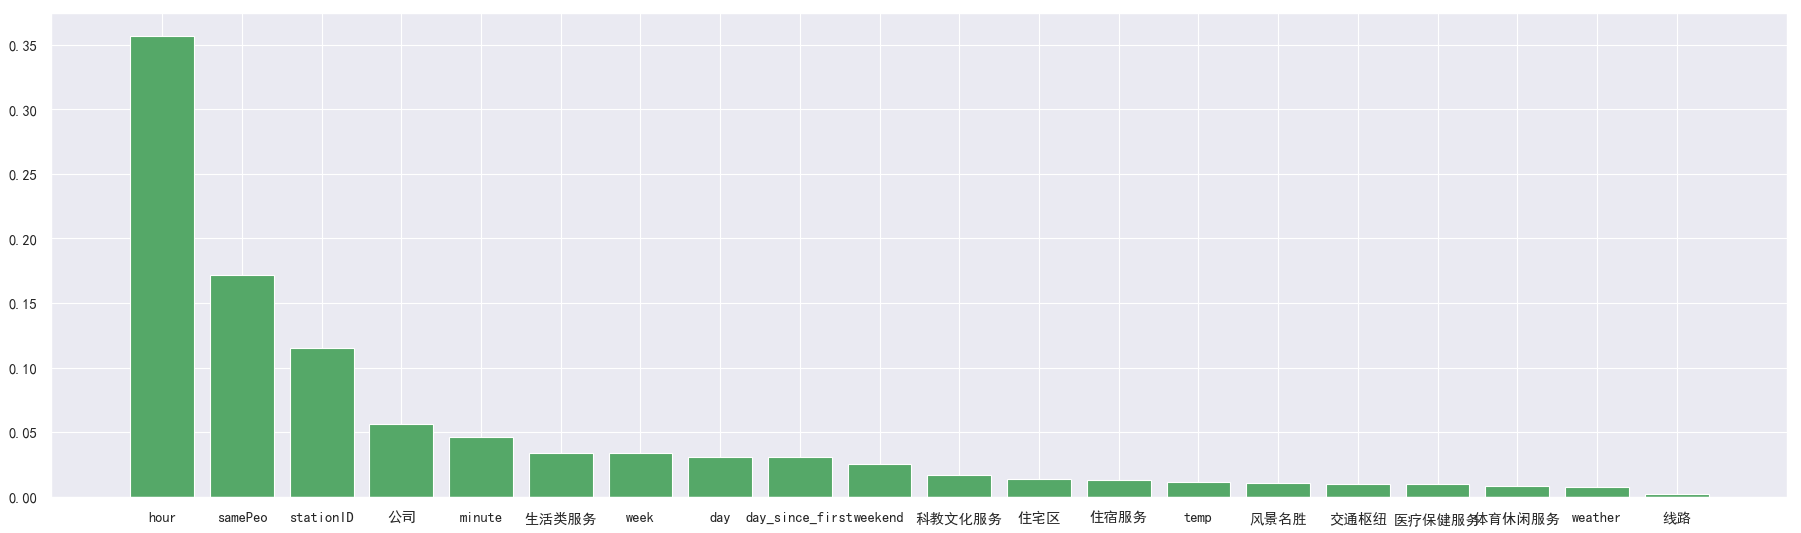

In [68]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
%matplotlib inline

plt.figure(figsize = (28, 8), dpi = 80)
plt.bar(feature[index], importances[index], color="g", align="center")
plt.tick_params(labelsize=13)     

In [69]:
# 26号为周六
test_26 = pd.read_csv(path + 'Metro_testB/testB_record_2019-01-26.csv')
df26 = get_more_features(test_26)  
df26.head()

,stationID,lineID,inNums,outNums,day,week,weekend,hour,minute,samePeo,...,医疗保健服务,住宿服务,风景名胜,科教文化服务,交通枢纽,生活类服务,公司,住宅区,temp,weather
0,0,1,0.0,1.0,26,6,1,0,0,0.253999,...,5,2,3,6,21,82,22,10,3.0,1
1,0,1,0.0,3.0,26,6,1,0,10,0.253999,...,5,2,3,6,21,82,22,10,3.0,1
2,0,1,0.0,2.0,26,6,1,0,20,0.253999,...,5,2,3,6,21,82,22,10,3.0,1
3,0,1,0.0,0.0,26,6,1,0,30,0.253999,...,5,2,3,6,21,82,22,10,3.0,1
4,0,1,0.0,0.0,26,6,1,0,40,0.253999,...,5,2,3,6,21,82,22,10,3.0,1


In [70]:
df26_X = df26.iloc[:, data_columns]
df26_y = df26.iloc[:, label_columns]

In [71]:
df26_y_pre = rf_reg.predict(df26_X)

In [72]:
rf_reg.score(df26_X, df26_y)

0.01211131477563617

In [73]:
# 预测周末准确率感人
mean_absolute_error(df26_y, df26_y_pre)

75.74335281165287

### 分日期预测

#### 用全月的工作日预测28号，周一

In [87]:
df_train_weekday = df_train[df_train['weekend']==0]
df_train_weekend = df_train[df_train['weekend']==1]

In [88]:
df_mon_X = df_train_weekday.iloc[:, data_columns]
df_mon_y = df_train_weekday.iloc[:, label_columns]

In [89]:
from sklearn.ensemble import RandomForestRegressor

rf_reg_mon = RandomForestRegressor(n_estimators=500, random_state=666, oob_score=True, n_jobs=-1)
rf_reg_mon.fit(df_mon_X, df_mon_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=666, verbose=0, warm_start=False)

In [90]:
df28_y_pre = rf_reg_mon.predict(df28_X)

In [91]:
rf_reg_mon.score(df28_X, df28_y)

0.9549102301778368

In [92]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df28_y, df28_y_pre)

17.059564278455287

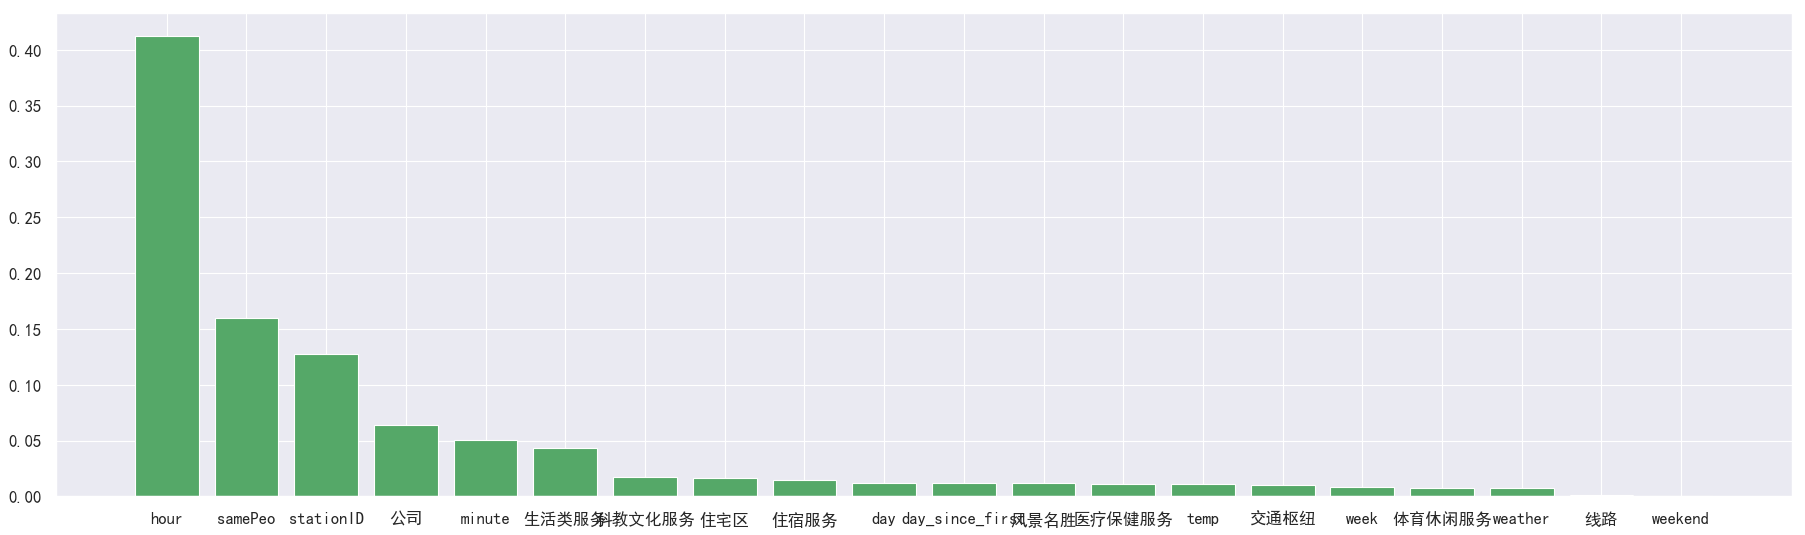

In [94]:
feature = df_mon_X.columns
importances = rf_reg_mon.feature_importances_
index = np.argsort(importances)[::-1]
feature[index]

plt.figure(figsize = (28, 8), dpi = 80)
plt.bar(feature[index], importances[index], color="g", align="center")
plt.tick_params(labelsize=15)     

#### 用上周的工作日 + 全月的周一，预测28号

In [153]:
df_train_4week_mon = df_train[(df_train['weekend']==0) & ((df_train['day']>20) | (df_train['week']==1))]

In [96]:
df_pro_X = df_train_4week_mon.iloc[:, data_columns]
df_pro_y = df_train_4week_mon.iloc[:, label_columns]

In [101]:
rf_reg_pro = RandomForestRegressor(n_estimators=500, oob_score=True, n_jobs=-1)
rf_reg_pro.fit(df_pro_X, df_pro_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [102]:
rf_reg_pro.score(df28_X, df28_y)

0.9643896360865573

In [103]:
df28_y_pre = rf_reg_pro.predict(df28_X)

In [104]:
mean_absolute_error(df28_y, df28_y_pre)

14.744007452574412

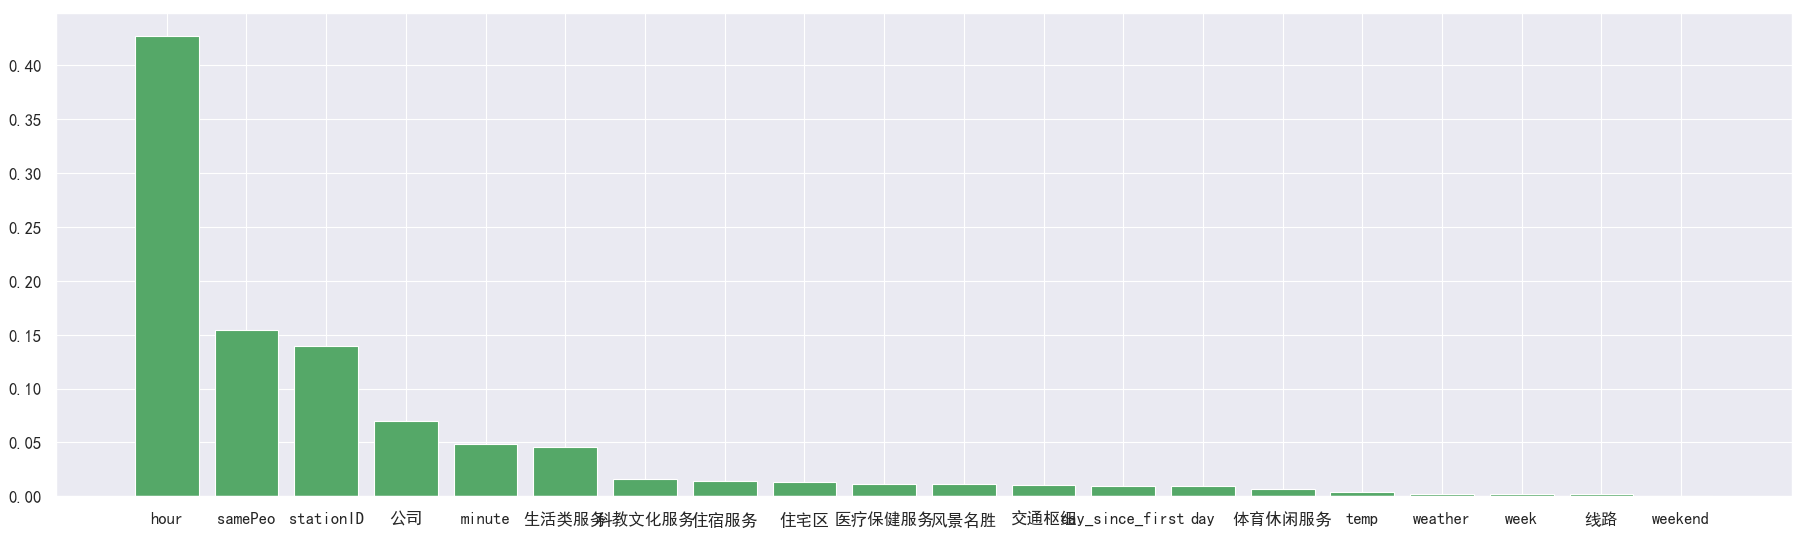

In [105]:
feature = df_pro_X.columns
importances = rf_reg_pro.feature_importances_
index = np.argsort(importances)[::-1]
feature[index]

plt.figure(figsize = (28, 8), dpi = 80)
plt.bar(feature[index], importances[index], color="g", align="center")
plt.tick_params(labelsize=15)  

#### xgboost

In [154]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_train_4week_mon, test_size = 0.2, random_state=1)

train_X = train.iloc[:, data_columns]
train_y_in  = train.iloc[:, 2]
train_y_out = train.iloc[:, 3]

valid_X = valid.iloc[:, data_columns]
valid_y_in  = valid.iloc[:, 2]
valid_y_out = valid.iloc[:, 3]

#xgb矩阵赋值
xgb_train_in = xgb.DMatrix(train_X, label=train_y_in)
xgb_val_in = xgb.DMatrix(valid_X, label=valid_y_in)

xgb_train_out = xgb.DMatrix(train_X, label=train_y_out)
xgb_val_out = xgb.DMatrix(valid_X, label=valid_y_out)

df28_X = df28.iloc[:, data_columns]
xgb_test = xgb.DMatrix(df28_X)
y_test_in  = df28.iloc[:, 2]
y_test_out = df28.iloc[:, 3]

In [159]:
watchlist = [(xgb_train_in, 'train'), (xgb_val_in, 'val')]
xgb_params = {'eta': 0.02, 'gamma': 0, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 
              'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True}

In [160]:
xgb_reg_pro_in = xgb.train(xgb_params, xgb_train_in, num_boost_round=3000, evals=watchlist,
                   early_stopping_rounds=100, verbose_eval=200)

[0]	train-mae:100.387	val-mae:101.484
Multiple eval metrics have been passed: 'val-mae' will be used for early stopping.

Will train until val-mae hasn't improved in 100 rounds.
[200]	train-mae:20.6485	val-mae:21.3038
[400]	train-mae:14.4654	val-mae:15.5223
[600]	train-mae:12.449	val-mae:13.9002
[800]	train-mae:11.403	val-mae:13.1593
[1000]	train-mae:10.6632	val-mae:12.6961
[1200]	train-mae:10.1873	val-mae:12.4223
[1400]	train-mae:9.80762	val-mae:12.2259
[1600]	train-mae:9.46062	val-mae:12.0564
[1800]	train-mae:9.17335	val-mae:11.9333
[2000]	train-mae:8.91966	val-mae:11.8315
[2200]	train-mae:8.70416	val-mae:11.7621
[2400]	train-mae:8.51246	val-mae:11.7035
[2600]	train-mae:8.3408	val-mae:11.6556
[2800]	train-mae:8.17267	val-mae:11.6093
[2999]	train-mae:8.02298	val-mae:11.5726


In [161]:
xgb_pro_in = xgb_reg_pro_in.predict(xgb_test, ntree_limit=xgb_reg_pro_in.best_ntree_limit)

In [162]:
mean_absolute_error(xgb_pro_in, y_test_in)

15.60935169315536

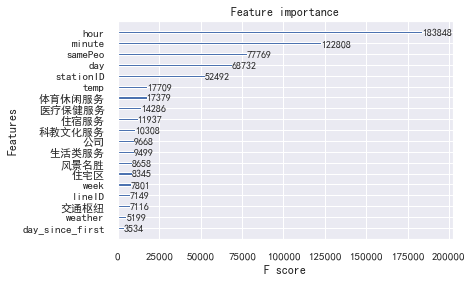

In [164]:
plot_importance(xgb_reg_pro_in)

##### 添加的特征是否有效

In [666]:
df_base_X = df_train_4week_mon.iloc[:, [0,1,4,5,6,7,8,9,10]]
df_base_y = df_train_4week_mon.iloc[:, [2,3]]

In [667]:
df28_base_X = df28.iloc[:, [0,1,4,5,6,7,8,9,10]]
df28_base_y = df28.iloc[:, [2,3]]

In [668]:
rf_reg_base = RandomForestRegressor(n_estimators=500, random_state=666, oob_score=True, n_jobs=-1)
rf_reg_base.fit(df_base_X, df_base_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=666, verbose=0, warm_start=False)

<BarContainer object of 9 artists>

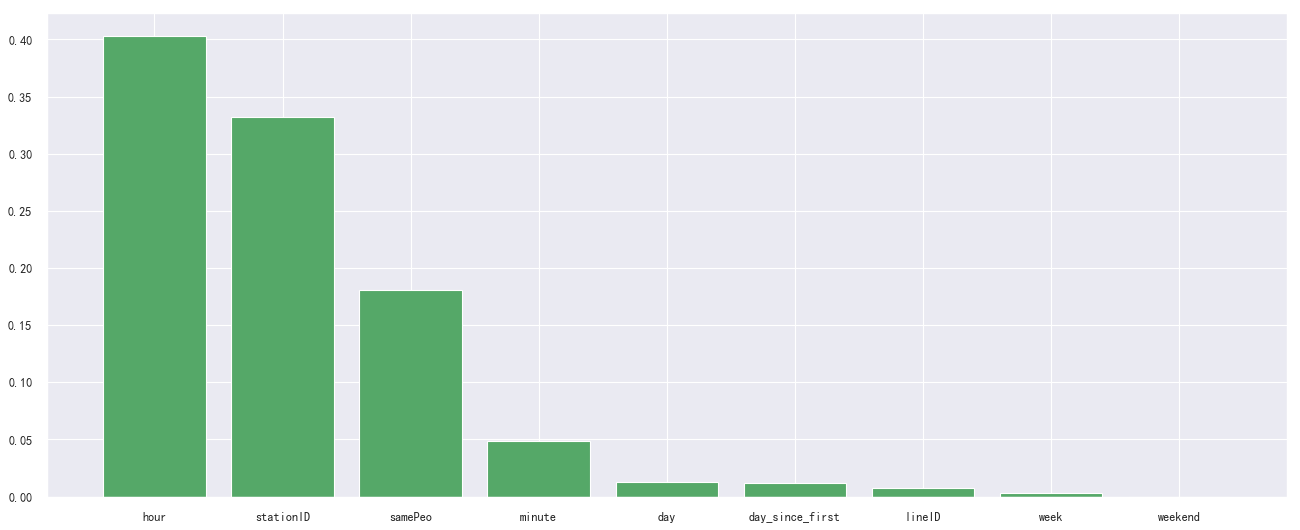

In [669]:
feature = df_base_X.columns
importances = rf_reg_base.feature_importances_
index = np.argsort(importances)[::-1]
feature[index]

plt.figure(figsize = (20, 8), dpi = 80)
plt.bar(feature[index], importances[index], color="g", align="center")

In [670]:
rf_reg_base.score(df28_base_X, df28_base_y)

0.9624652817532721

In [671]:
df28_base_y_pre = rf_reg_base.predict(df28_base_X)

In [672]:
# 加了poi与weather将mae提高了0.8
mean_absolute_error(df28_base_y, df28_base_y_pre)

15.31923763550129

### 分站点预测

In [601]:
# 站点0~80，分别预测后组合
def predict_ID(df_train, df_test):
    df_pre = np.zeros(shape=(1,2))
   
    for i in range(81):
        df_train_sta = df_train[df_train['stationID']==i]
        df_X = df_train_sta.iloc[:, [4,5,6,7,8,9,10,20,21]]
        df_y = df_train_sta.iloc[:, [2,3]]
        
        df_test_X = df_test[df_test['stationID']==i].iloc[:, [4,5,6,7,8,9,10,20,21]]
        
        rf_reg = RandomForestRegressor(n_estimators=500, oob_score=True, n_jobs=-1)
        rf_reg.fit(df_X, df_y)
        
        df_test_y_pre = rf_reg.predict(df_test_X)  
        df_pre = np.vstack((df_pre, df_test_y_pre))
    
    df_pre = np.delete(df_pre, 0, axis=0)    #删除初始创建的第一行
    
    return df_pre
    

In [602]:
df_pre_s = predict_ID(df_train, df28)

In [603]:
mean_absolute_error(df28_y, df_pre_s)

17.579825118563605

### 分站点+日期预测

In [604]:
df_pre_st = predict_ID(df_train_4week_mon, df28)

In [605]:
mean_absolute_error(df28_y, df_pre_st)

14.579912855690932